## Residual Dense Neural Networks (RDN) 
Use environment tf_env as it has tensorflow 2.10 and CUDA 11.2

In this ML model, we attempt to increase the resolution of satellite precipitation images from IMERG dataset. IMERG dataset provides resolution at 0.1 x 0.1 degrees which is approximately 10km by 10km. We attempt to increase resolution to 2km by 2km by upscaling 5x.

Model architecture. Given an image of size (173,174) we do
1) Slice to (170,170), label this as "high res (hr)"
2) Downscale to coarser resolution (170,170) -> (34,34), label this as "low res (lr)"
3) Run rainFARM algorith and upscale lr back to (170,170), label this as "super resolved (sr)"
4) Train the RDN with sr as input and hr as target. This aims to correct the rainFARM algorithm
5) Take the original (170,170) and upscale using rainFARM to (850,850) and input into the trained model to produce a corrected super resolved upscaled image.

In [2]:
import tensorflow as tf
import os
import xarray as xr
import numpy as np
from scipy.ndimage import zoom
from pysteps.downscaling import rainfarm
import tensorflow as tf
import random
import numpy as np
import xarray as xr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import zoom
import tensorflow as tf
from tqdm import tqdm
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

c:\Users\userAdmin\anaconda3\envs\tf_env\lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


Pysteps configuration file found at: c:\Users\userAdmin\anaconda3\envs\tf_env\lib\site-packages\pysteps\pystepsrc

Num GPUs Available:  1
2.10.0


Checking of available GPUs

In [2]:
# List all physical devices
devices = tf.config.list_physical_devices()
print("All physical devices:", devices)

# List all GPUs
gpus = tf.config.list_physical_devices('GPU')
print("All GPUs:", gpus)

# Get detailed GPU information
for gpu in gpus:
    print("GPU details:", gpu)

# Optionally, print which GPU is being used for a specific operation
with tf.device('/GPU:0'):
    a = tf.constant(1.0)
    b = tf.constant(2.0)
    c = a + b
    print("Result:", c)


All physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Result: tf.Tensor(3.0, shape=(), dtype=float32)


Data initialization and preprocessing

In [ ]:
# Function to preprocess images
def preprocess_image(file_path, downscale_factor):
    ds = xr.open_dataset(file_path)
    precip = ds['precipitation'].values[0, :170, :170]
    downscale_size = (precip.shape[0] // downscale_factor, precip.shape[1] // downscale_factor)
    B = zoom(precip, (downscale_size[0] / precip.shape[0], downscale_size[1] / precip.shape[1]), order=2)
    C = rainfarm.downscale(B, downscale_factor)
    return precip[..., np.newaxis], C[..., np.newaxis]

# Function to load the dataset
def load_dataset(folder_path, downscale_factor, sample_size, description):
    files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.nc')]
    sampled_files = random.sample(files, sample_size)
    hr_images, lr_images = [], []
    
    for file_path in tqdm(sampled_files, desc=description, unit="file"):
        hr_image, lr_image = preprocess_image(file_path, downscale_factor)
        hr_images.append(hr_image)
        lr_images.append(lr_image)
    
    return np.array(hr_images), np.array(lr_images)

# Folder path and parameters
folder_path = r'C:\Users\userAdmin\Desktop\Rain data files\IMERG 10yrs\data files'
downscale_factor = 5
sample_size = 26000  # Random sample size of 20,000 files
validation_size = 1000

# Load the training dataset
hr_train_data, lr_train_data = load_dataset(folder_path, downscale_factor, sample_size - validation_size, "Processing training files")

# Load the validation dataset
hr_val_data, lr_val_data = load_dataset(folder_path, downscale_factor, validation_size, "Processing validation files")

# Function to create TensorFlow datasets
def create_tf_dataset(hr_data, lr_data, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((lr_data, hr_data))
    dataset = dataset.cache().shuffle(len(hr_data)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset



Model architecture of Residual Dense Network (simplified)

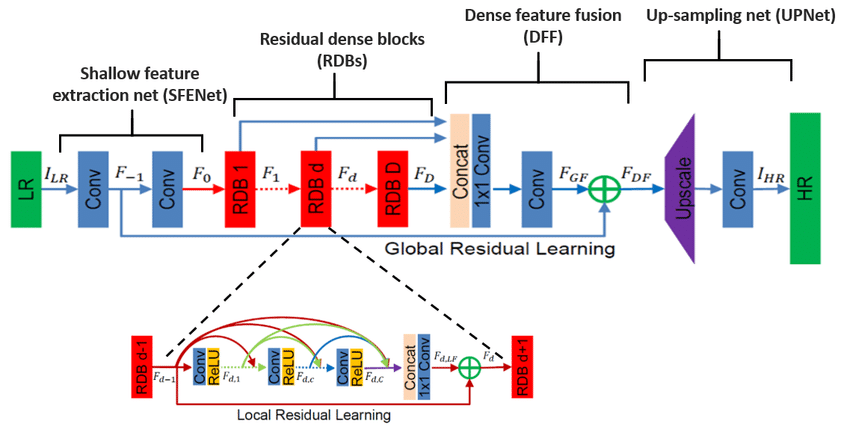

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define Residual Dense Block
class ResidualDenseBlock(layers.Layer):
    def __init__(self, filters, growth_rate, **kwargs):
        super(ResidualDenseBlock, self).__init__(**kwargs)
        self.filters = filters
        self.growth_rate = growth_rate
        self.conv1 = layers.Conv2D(growth_rate, 3, padding='same', kernel_initializer='he_normal')
        self.batch_norm1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(growth_rate, 3, padding='same', kernel_initializer='he_normal')
        self.batch_norm2 = layers.BatchNormalization()
        self.conv3 = layers.Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')
        self.batch_norm3 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.concat = layers.Concatenate()
        self.dropout = layers.Dropout(0.5)

    def get_config(self):
        config = super(ResidualDenseBlock, self).get_config()
        config.update({
            'filters': self.filters,
            'growth_rate': self.growth_rate
        })
        return config

    def call(self, x):
        out1 = self.relu(self.batch_norm1(self.conv1(x)))
        out2 = self.relu(self.batch_norm2(self.conv2(self.concat([x, out1]))))
        out3 = self.dropout(self.batch_norm3(self.conv3(self.concat([x, out1, out2]))))
        return out3 * 0.2 + x

# Define Residual Dense Network
def build_rdn_model(num_channels=1, num_features=64, growth_rate=32, num_blocks=12):
    inputs = layers.Input(shape=(None, None, num_channels))
    x = layers.Conv2D(num_features, 3, padding='same', kernel_initializer='he_normal')(inputs)
    for _ in range(num_blocks):
        x = ResidualDenseBlock(num_features, growth_rate)(x)
    x = layers.Conv2D(num_channels, 3, padding='same', kernel_initializer='he_normal')(x)
    model = models.Model(inputs, x)
    return model

model = build_rdn_model()
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    640       
                                                                 
 residual_dense_block (Resid  (None, None, None, 64)   120448    
 ualDenseBlock)                                                  
                                                                 
 residual_dense_block_1 (Res  (None, None, None, 64)   120448    
 idualDenseBlock)                                                
                                                                 
 residual_dense_block_2 (Res  (None, None, None, 64)   120448    
 idualDenseBlock)                                                
                                                             

Model: "Single_RDB_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, None, 1)]   0         
                                                                 
 initial_conv (Conv2D)       (None, None, None, 64)    640       
                                                                 
 RDB_1 (ResidualDenseBlock)  (None, None, None, 64)    120448    
                                                                 
 output_conv (Conv2D)        (None, None, None, 1)     577       
                                                                 
Total params: 121,665
Trainable params: 121,409
Non-trainable params: 256
_________________________________________________________________


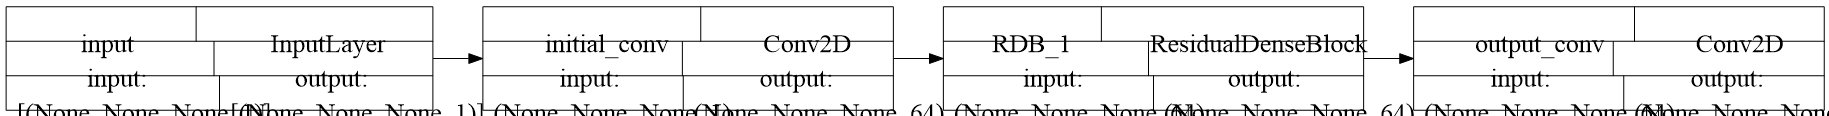

In [4]:
# Define a simple model with one Residual Dense Block
def build_single_rdb_model(num_channels=1, num_features=64, growth_rate=32):
    inputs = layers.Input(shape=(None, None, num_channels), name='input')
    x = layers.Conv2D(num_features, 3, padding='same', kernel_initializer='he_normal', name='initial_conv')(inputs)
    x = ResidualDenseBlock(num_features, growth_rate, name='RDB_1')(x)
    x = layers.Conv2D(num_channels, 3, padding='same', kernel_initializer='he_normal', name='output_conv')(x)
    model = models.Model(inputs, x, name='Single_RDB_Model')
    return model

# Create the model
single_rdb_model = build_single_rdb_model()
single_rdb_model.summary()

from tensorflow.keras.utils import plot_model

# Plot the model with one Residual Dense Block
plot_model(single_rdb_model, to_file='single_rdb_model.png', show_shapes=True, show_layer_names=True, dpi=100, expand_nested=True, rankdir='LR')

Training

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import matplotlib.pyplot as plt
# Create TensorFlow datasets
batch_size = 6
train_dataset = create_tf_dataset(hr_train_data, lr_train_data, batch_size)
val_dataset = create_tf_dataset(hr_val_data, lr_val_data, batch_size)
# Custom callback to store training and validation loss
class LossHistory(Callback):
    def on_train_begin(self, logs=None):
        self.train_losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

# Ensure a directory exists for saving checkpoints
checkpoint_dir = './training_checkpoints_25k'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'ckpt_{epoch}'),
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)

# Create an instance of the custom callback
loss_history = LossHistory()

# Build and compile the model
generator = build_rdn_model()
generator.compile(optimizer="adam", loss='mse')

# Load the latest checkpoint if available
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    print(f"Loading weights from {latest_checkpoint}")
    generator.load_weights(latest_checkpoint)

# Determine the starting epoch based on the latest checkpoint
initial_epoch = int(latest_checkpoint.split('_')[-1]) if latest_checkpoint else 0

# Train the model
history = generator.fit(
    train_dataset,
    epochs=20,
    initial_epoch=initial_epoch,
    callbacks=[checkpoint_callback, loss_history],
    validation_data=val_dataset
)

# Save the final model
generator.save('improved_RDN_25k.h5')



Epoch 1/20
4167/4167 [==============================] - ETA: 0s - loss: 0.8222
Epoch 1: saving model to ./training_checkpoints_25k\ckpt_1
4167/4167 [==============================] - 1781s 425ms/step - loss: 0.8222 - val_loss: 0.7619
Epoch 2/20
4167/4167 [==============================] - ETA: 0s - loss: 0.7247
Epoch 2: saving model to ./training_checkpoints_25k\ckpt_2
4167/4167 [==============================] - 1815s 436ms/step - loss: 0.7247 - val_loss: 0.6983
Epoch 3/20
4167/4167 [==============================] - ETA: 0s - loss: 0.6759
Epoch 3: saving model to ./training_checkpoints_25k\ckpt_3
4167/4167 [==============================] - 1814s 435ms/step - loss: 0.6759 - val_loss: 0.6793
Epoch 4/20
4167/4167 [==============================] - ETA: 0s - loss: 0.6593
Epoch 4: saving model to ./training_checkpoints_25k\ckpt_4
4167/4167 [==============================] - 1813s 435ms/step - loss: 0.6593 - val_loss: 0.6694
Epoch 5/20
4167/4167 [==============================] - ETA: 0s 

Training and validation loss

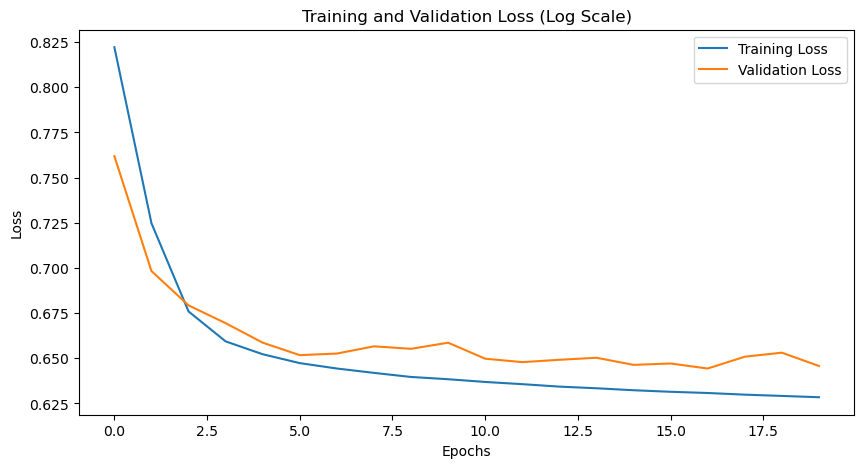

In [6]:
# Plot the training and validation loss with log scale
plt.figure(figsize=(10, 5))
plt.plot(loss_history.train_losses, label='Training Loss')
plt.plot(loss_history.val_losses, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Log Scale)')
plt.legend()
plt.show()

Testing and visualisation

1/1 [==============================] - 0s 383ms/step


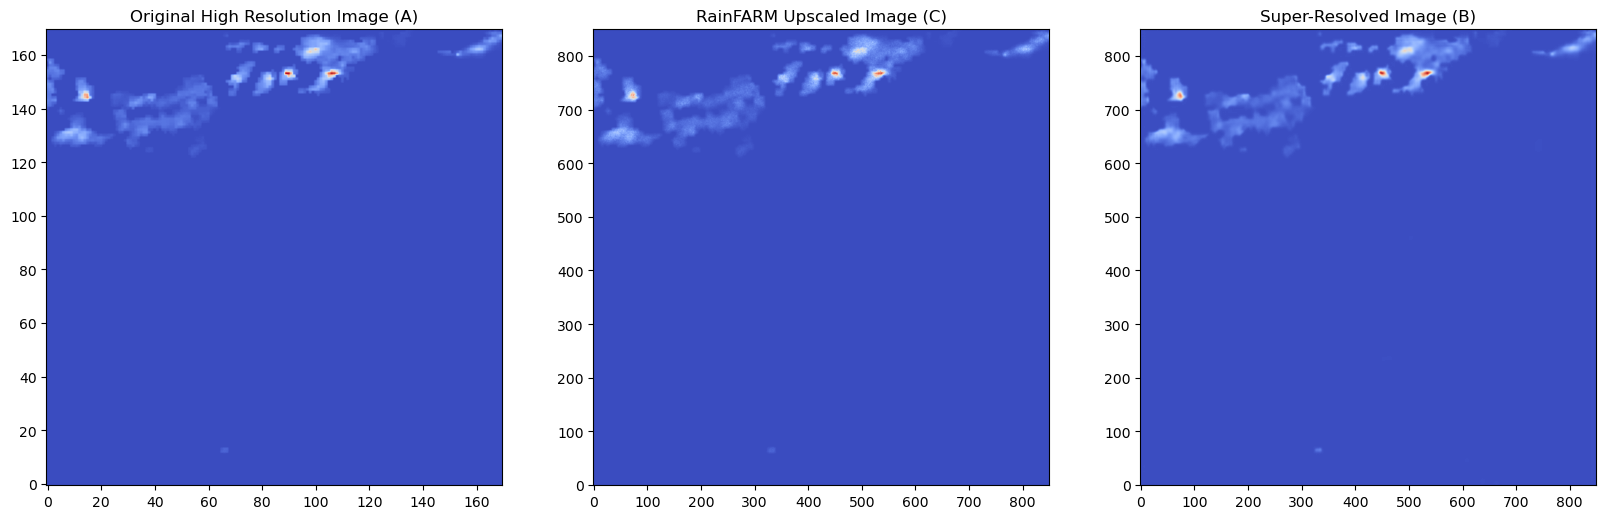

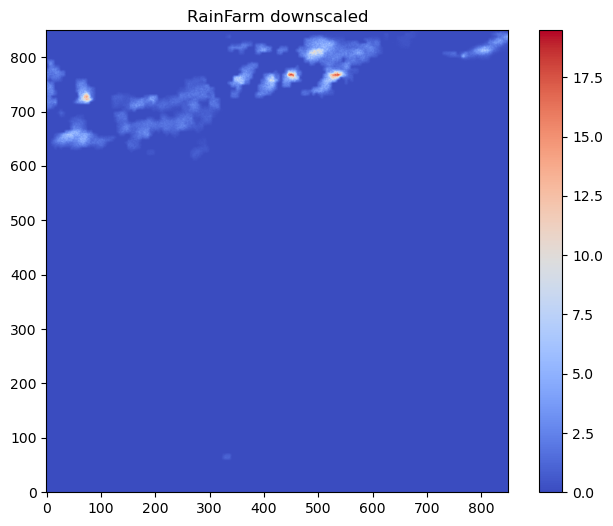

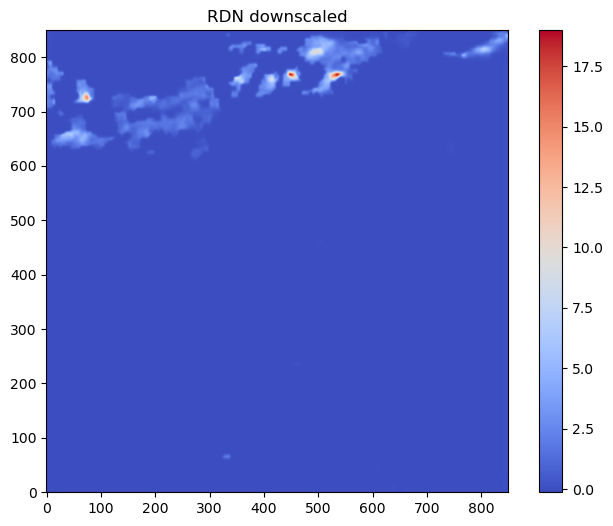

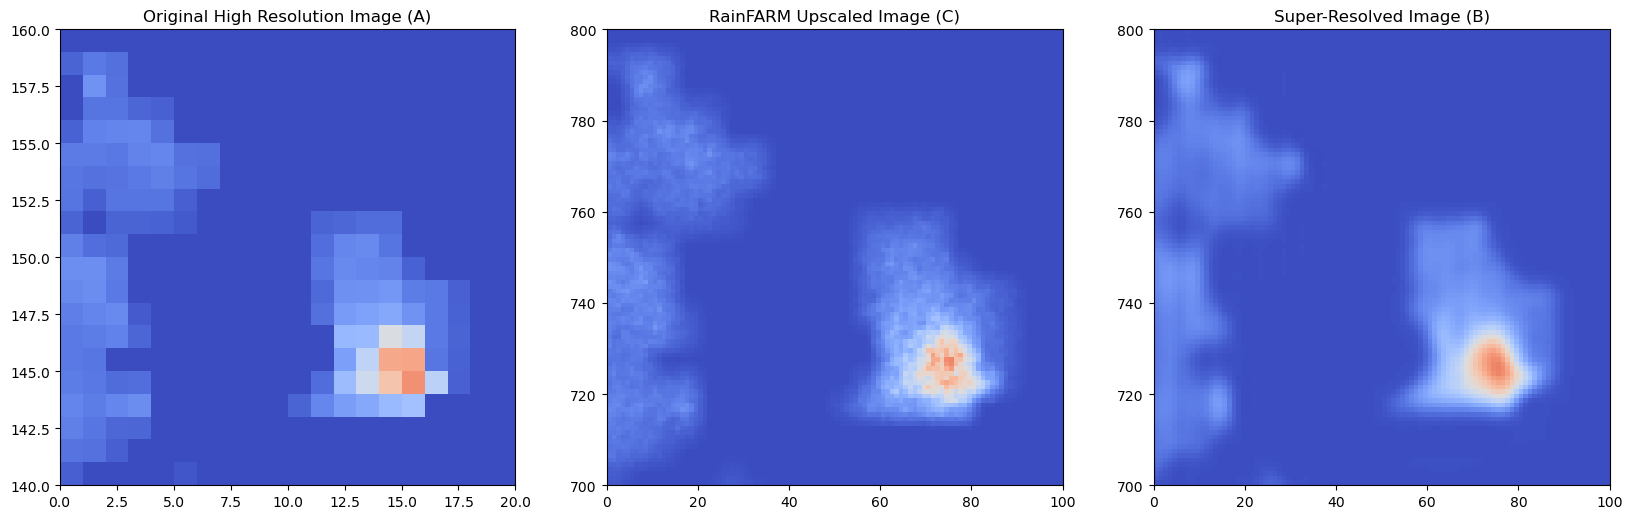

In [24]:
generator = tf.keras.models.load_model('improved_RDN_25k.h5', custom_objects={'ResidualDenseBlock': ResidualDenseBlock})

new_file_path = r'c:\Users\userAdmin\Desktop\Climate Database\GSMaP_files\extracted\2014\02\gsmap_nrt.20140203.0300.dat.nc'
downscale_factor = 5
def test_image(file_path, downscale_factor):
    ds = xr.open_dataset(file_path)
    precip = ds['precipitation'].values[:170, :170]
    downscale_size = (precip.shape[0] // 1, precip.shape[1] // 1)
    B = zoom(precip, (downscale_size[0] / precip.shape[0], downscale_size[1] / precip.shape[1]), order=1)
    C = rainfarm.downscale(B, downscale_factor)
    return precip[..., np.newaxis], C[..., np.newaxis]
hr_image, lr_image = test_image(new_file_path, downscale_factor)

sr_image = generator.predict(tf.convert_to_tensor([lr_image]))[0, ..., 0]

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(20, 15))
axes[0].imshow(hr_image[..., 0], cmap='coolwarm', origin='lower')
axes[0].set_title('Original High Resolution Image (A)')

axes[1].imshow(lr_image[..., 0], cmap='coolwarm', origin='lower')
axes[1].set_title('RainFARM Upscaled Image (C)')
plt.figure(figsize=(8,6))
plt.imshow(lr_image[...,0], cmap='coolwarm', origin='lower')
plt.colorbar()
plt.title('RainFarm downscaled')
plt.savefig('rainfarm_downscaled.png')

axes[2].imshow(sr_image, cmap='coolwarm', origin='lower')
axes[2].set_title('Super-Resolved Image (B)')

plt.figure(figsize=(8,6))
plt.imshow(sr_image, cmap='coolwarm', origin='lower')
plt.colorbar()
plt.title('RDN downscaled')
plt.savefig('RDN_downscaled.png')

plt.show()

x_start, x_end, y_start, y_end = 0,20,140,160
downscale_factor = 5
fig, axes = plt.subplots(1, 3, figsize=(20, 15))
axes[0].imshow(hr_image[..., 0], cmap='coolwarm', origin='lower',
               extent=(0, hr_image.shape[1], 0, hr_image.shape[0]))
axes[0].set_xlim(0, 20)
axes[0].set_ylim(140, 160)
axes[0].set_title('Original High Resolution Image (A)')

axes[1].imshow(lr_image[..., 0], cmap='coolwarm', origin='lower',
               extent=(0, lr_image.shape[1], 0, lr_image.shape[0]))
axes[1].set_xlim(0,100)
axes[1].set_ylim(700,800)
axes[1].set_title('RainFARM Upscaled Image (C)')

axes[2].imshow(sr_image, cmap='coolwarm', origin='lower',
               extent=(0, sr_image.shape[1], 0, sr_image.shape[0]))
axes[2].set_xlim(0,100)
axes[2].set_ylim(700,800)
axes[2].set_title('Super-Resolved Image (B)')



plt.show()



Evaluation metrics


1/1 [==============================] - 0s 41ms/step
MAE (A, B): 0.1170651532175108
MAE (A, C): 0.09287630021572113
RMSE (A, B): 0.6878452580993063
RMSE (A, C): 0.5053750276565552
PSNR (A, B): 32.60234670679486
PSNR (A, C): 35.27988579946609
SSIM (A, B): 0.918966382346823
SSIM (A, C): 0.9412183643115436
MS-SSIM (A, B): 0.9373403191566467
MS-SSIM (A, C): 0.767970860004425
GMSD (A, B): 0.08626221120357513
GMSD (A, C): 0.10537485778331757


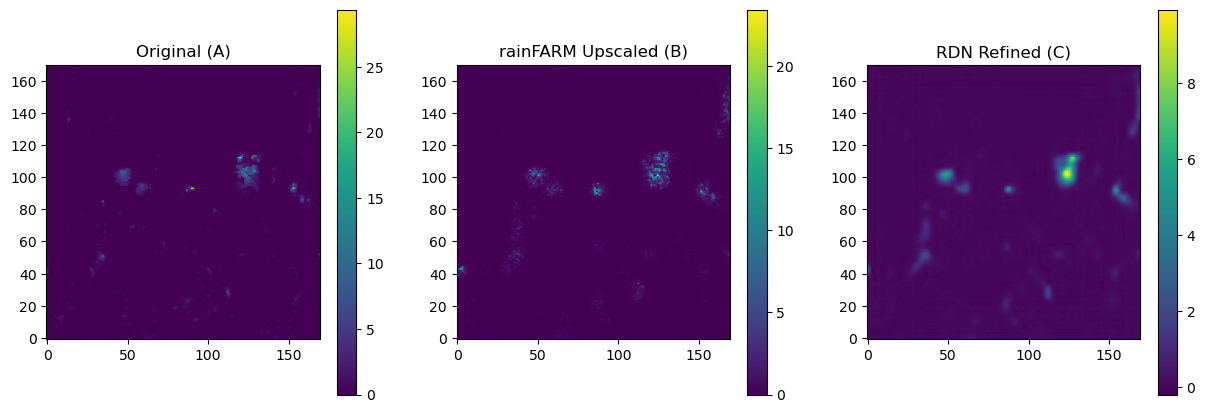

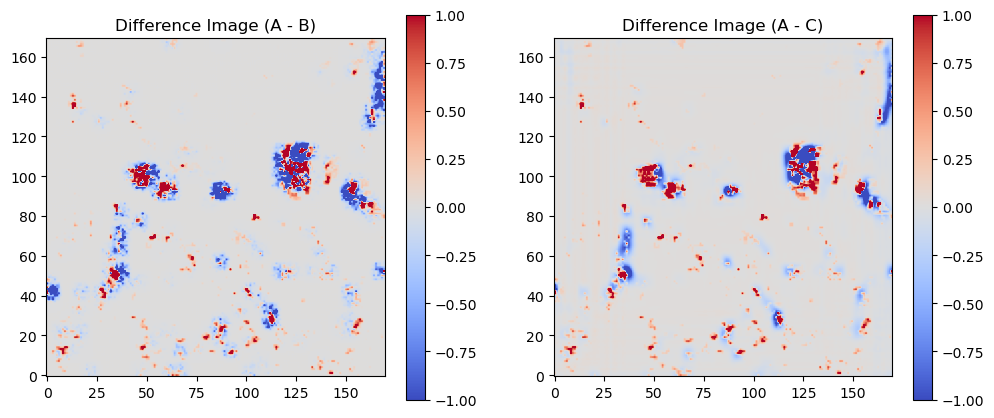

In [33]:
import tensorflow as tf
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
import xarray as xr
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import piq
import torch

# Function to preprocess images (existing)
def preprocess_image(file_path, downscale_factor):
    ds = xr.open_dataset(file_path)
    precip = ds['precipitation'].values[0,:170, :170]
    downscale_size = (precip.shape[0] // downscale_factor, precip.shape[1] // downscale_factor)
    B = zoom(precip, (downscale_size[0] / precip.shape[0], downscale_size[1] / precip.shape[1]), order=1)
    C = rainfarm.downscale(B, downscale_factor)
    return precip[..., np.newaxis], C[..., np.newaxis]

# Load sample data
A, B = preprocess_image(r"c:\Users\userAdmin\Desktop\Climate Database\IMERG\data files\20230524-1930.nc", downscale_factor=5)

# Predict using RDN model
C = generator.predict(B[np.newaxis, ...])[0]

# Ensure shapes match for A, B, C
assert A.shape == B.shape == C.shape

# Normalize images to [0, 1] range for piq metrics
A_norm = (A - np.min(A)) / (np.max(A) - np.min(A))
B_norm = (B - np.min(B)) / (np.max(B) - np.min(B))
C_norm = (C - np.min(C)) / (np.max(C) - np.min(C))

# Convert images to PyTorch tensors for piq metrics
A_tensor = torch.tensor(A_norm[..., 0], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
B_tensor = torch.tensor(B_norm[..., 0], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
C_tensor = torch.tensor(C_norm[..., 0], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
# Mean Absolute Error (MAE)
mae_A_B = mae(A.flatten(), B.flatten())
mae_A_C = mae(A.flatten(), C.flatten())

# Root Mean Square Error (RMSE)
rmse_A_B = np.sqrt(mse(A.flatten(), B.flatten()))
rmse_A_C = np.sqrt(mse(A.flatten(), C.flatten()))
# Calculate PSNR
psnr_A_B = psnr(A, B, data_range=np.max(A) - np.min(A))
psnr_A_C = psnr(A, C, data_range=np.max(A) - np.min(A))

# Calculate SSIM
ssim_A_B = ssim(A[..., 0], B[..., 0], data_range=np.max(A) - np.min(A))
ssim_A_C = ssim(A[..., 0], C[..., 0], data_range=np.max(A) - np.min(A))

# Calculate MS-SSIM
ms_ssim_A_B = piq.multi_scale_ssim(A_tensor, B_tensor, data_range=1.0).item()
ms_ssim_A_C = piq.multi_scale_ssim(A_tensor, C_tensor, data_range=1.0).item()

# Calculate GMSD
gmsd_A_B = piq.gmsd(A_tensor, B_tensor, data_range=1.0).item()
gmsd_A_C = piq.gmsd(A_tensor, C_tensor, data_range=1.0).item()

print(f'MAE (A, B): {mae_A_B}')
print(f'MAE (A, C): {mae_A_C}')
print(f'RMSE (A, B): {rmse_A_B}')
print(f'RMSE (A, C): {rmse_A_C}')
print(f'PSNR (A, B): {psnr_A_B}')
print(f'PSNR (A, C): {psnr_A_C}')
print(f'SSIM (A, B): {ssim_A_B}')
print(f'SSIM (A, C): {ssim_A_C}')
print(f'MS-SSIM (A, B): {ms_ssim_A_B}')
print(f'MS-SSIM (A, C): {ms_ssim_A_C}')
print(f'GMSD (A, B): {gmsd_A_B}')
print(f'GMSD (A, C): {gmsd_A_C}')


# Plot the images for visual comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original (A)')
plt.imshow(A[..., 0], cmap='viridis',origin='lower')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title('rainFARM Upscaled (B)')
plt.imshow(B[..., 0], cmap='viridis',origin='lower')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title('RDN Refined (C)')
plt.imshow(C[..., 0], cmap='viridis',origin='lower')
plt.colorbar()

plt.show()
import matplotlib.pyplot as plt

# Calculate difference images
diff_A_B = A - B
diff_A_C = A - C

# Plot the difference images
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Difference Image (A - B)')
plt.imshow(diff_A_B, cmap='coolwarm', vmin=-1, vmax=1,origin='lower')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Difference Image (A - C)')
plt.imshow(diff_A_C, cmap='coolwarm', vmin=-1, vmax=1,origin='lower')
plt.colorbar()

plt.show()


Mass conversion of NC file over longer time frame

In [4]:
import xarray as xr
import numpy as np
from scipy.ndimage import zoom
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd


# Load the pre-trained model
generator = load_model('improved_RDN_25k.h5', custom_objects={'ResidualDenseBlock': ResidualDenseBlock})

# Function to process a single time frame
def process_time_frame(precip, downscale_factor):
    downscale_size = (precip.shape[0] // 1, precip.shape[1] // 1)
    B = zoom(precip, (downscale_size[0] / precip.shape[0], downscale_size[1] / precip.shape[1]), order=1)
    C = rainfarm.downscale(B, downscale_factor)
    return C

# Function to convert cftime to standard datetime
def convert_time(cftime_array):
    return np.array([pd.to_datetime(str(t)) for t in cftime_array])

# Function to process and save NetCDF
def process_nc_file(input_file_path, output_file_path, downscale_factor):
    ds = xr.open_dataset(input_file_path)
    precip_data = ds['precipitation'].values  # Assuming precipitation is a 3D array (time, lon, lat)
    
    # Initialize a list for super-resolved precipitation data
    sr_precip_list = []
    
    # Loop over time with tqdm progress bar
    for i in tqdm(range(precip_data.shape[0]), desc="Processing time frames", unit="frame"):  # Loop over time
        precip = precip_data[i, :, :]
        lr_precip = process_time_frame(precip.T, downscale_factor)  # Transpose to (lat, lon)
        lr_image = lr_precip[..., np.newaxis]
        with tf.device('/GPU:0'):  # Ensure the GPU is used
            sr_image = generator.predict(tf.convert_to_tensor([lr_image]), verbose=0)[0, ..., 0]
        sr_precip_list.append(sr_image.T)  # Transpose back to (lon, lat)

    # Convert the list to a numpy array
    sr_precip_data = np.array(sr_precip_list)
    converted_times = convert_time(ds['time'].values)
    
    # Create a new NetCDF file and save the super-resolved data
    with nc.Dataset(output_file_path, 'w', format='NETCDF4_CLASSIC') as ds_out:
        # Define dimensions
        ds_out.createDimension('time', sr_precip_data.shape[0])
        ds_out.createDimension('longitude', sr_precip_data.shape[1])
        ds_out.createDimension('latitude', sr_precip_data.shape[2])
        
        # Create variables
        times = ds_out.createVariable('time', np.float64, ('time',))
        longitudes = ds_out.createVariable('longitude', np.float32, ('longitude',))
        latitudes = ds_out.createVariable('latitude', np.float32, ('latitude',))
        precipitation = ds_out.createVariable('precipitation', np.float32, ('time', 'longitude', 'latitude'))
        
        # Assign data to variables
        times[:] = nc.date2num(converted_times, units='hours since 1970-01-01 00:00:00', calendar='gregorian')
        longitudes[:] = np.linspace(ds['lon'].values.min(), ds['lon'].values.max(), sr_precip_data.shape[1])
        latitudes[:] = np.linspace(ds['lat'].values.min(), ds['lat'].values.max(), sr_precip_data.shape[2])
        precipitation[:, :, :] = sr_precip_data
        
        # Add variable attributes
        times.units = 'hours since 1970-01-01 00:00:00'
        times.calendar = 'gregorian'
        longitudes.units = 'degrees_east'
        latitudes.units = 'degrees_north'
        precipitation.units = 'mm/hr'
        precipitation.long_name = "Super-Resolved Precipitation"
        
    print(f"NetCDF file '{output_file_path}' created successfully.")

# Run the function on your file
input_file_path = r'C:\Users\userAdmin\Desktop\Rain data files\IMERG 10yrs\2023_IMERG_annual.nc'
output_file_path = r'C:\Users\userAdmin\Desktop\Rain data files\IMERG 10yrs\2023_IMERG_annual_SR.nc'
downscale_factor = 5
process_nc_file(input_file_path, output_file_path, downscale_factor)



Processing time frames:   0%|          | 23/17388 [00:29<6:15:02,  1.30s/frame]


KeyboardInterrupt: 